In [ ]:
!pip install plotly
!pip install seaborn

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
spark = SparkSession.builder.appName('hye085').getOrCreate()

In [2]:
df = spark.read.csv('Datasets/hotel_bookings.csv',inferSchema=True,header=True)

In [33]:
df.columns

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [47]:
df.describe().show()

+-------+------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|       hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|pr

In [34]:
df.head()

Row(hotel='Resort Hotel', is_canceled=0, lead_time=342, arrival_date_year=2015, arrival_date_month='July', arrival_date_week_number=27, arrival_date_day_of_month=1, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=2, children='0', babies=0, meal='BB', country='PRT', market_segment='Direct', distribution_channel='Direct', is_repeated_guest=0, previous_cancellations=0, previous_bookings_not_canceled=0, reserved_room_type='C', assigned_room_type='C', booking_changes=3, deposit_type='No Deposit', agent=None, company=None, days_in_waiting_list=0, customer_type='Transient', adr=0.0, required_car_parking_spaces=0, total_of_special_requests=0, reservation_status='Check-Out', reservation_status_date='2015/7/1')

In [3]:
from pyspark.sql.types import IntegerType
df = df.withColumn("children", df["children"].cast(IntegerType()))
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nulla

In [36]:
df.select("hotel").show()

+------------+
|       hotel|
+------------+
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
|Resort Hotel|
+------------+
only showing top 20 rows



In [39]:
print((df.count(), len(df.columns)))

(119390, 32)


In [4]:
# View rows containing NULL values
import pyspark.sql.functions as pyfunc
from functools import reduce
df_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        df.agg(
            pyfunc.count(pyfunc.when(pyfunc.isnull(c), c)).alias('NULL_Count')
        ).select(pyfunc.lit(c).alias("Column_Name"), "NULL_Count")
        for c in df.columns
    )
)
df_agg_col.show(len(df.columns))

+--------------------+----------+
|         Column_Name|NULL_Count|
+--------------------+----------+
|               hotel|         0|
|         is_canceled|         0|
|           lead_time|         0|
|   arrival_date_year|         0|
|  arrival_date_month|         0|
|arrival_date_week...|         0|
|arrival_date_day_...|         0|
|stays_in_weekend_...|         0|
|stays_in_week_nights|         0|
|              adults|         0|
|            children|         4|
|              babies|         0|
|                meal|         0|
|             country|       488|
|      market_segment|         0|
|distribution_channel|         0|
|   is_repeated_guest|         0|
|previous_cancella...|         0|
|previous_bookings...|         0|
|  reserved_room_type|         0|
|  assigned_room_type|         0|
|     booking_changes|         0|
|        deposit_type|         0|
|               agent|     16340|
|             company|    112593|
|days_in_waiting_list|         0|
|       custom

In [5]:
# Replace missing values:
na_replacements = {"children":0.0, "country": "Unknown", "agent": 0, "company": 0}
df_clean = df.na.fill(na_replacements)
df_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        df_clean.agg(
            pyfunc.count(pyfunc.when(pyfunc.isnull(c), c)).alias('NULL_Count')
        ).select(pyfunc.lit(c).alias("Column_Name"), "NULL_Count")
        for c in df.columns
    )
)
df_agg_col.show(len(df_clean.columns))

+--------------------+----------+
|         Column_Name|NULL_Count|
+--------------------+----------+
|               hotel|         0|
|         is_canceled|         0|
|           lead_time|         0|
|   arrival_date_year|         0|
|  arrival_date_month|         0|
|arrival_date_week...|         0|
|arrival_date_day_...|         0|
|stays_in_weekend_...|         0|
|stays_in_week_nights|         0|
|              adults|         0|
|            children|         0|
|              babies|         0|
|                meal|         0|
|             country|         0|
|      market_segment|         0|
|distribution_channel|         0|
|   is_repeated_guest|         0|
|previous_cancella...|         0|
|previous_bookings...|         0|
|  reserved_room_type|         0|
|  assigned_room_type|         0|
|     booking_changes|         0|
|        deposit_type|         0|
|               agent|         0|
|             company|         0|
|days_in_waiting_list|         0|
|       custom

In [5]:
df_clean.groupBy('hotel').count().orderBy('count').show()

+------------+-----+
|       hotel|count|
+------------+-----+
|Resort Hotel|40060|
|  City Hotel|79330|
+------------+-----+



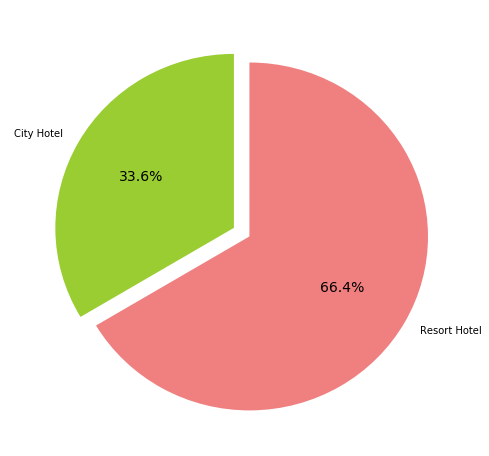

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Enlarging the pie chart
plt.rcParams['figure.figsize'] = 8,8

# Indexing labels. tolist() will convert the index to list for easy manipulation
label=df_clean.select('hotel').distinct().collect()
labels = [label[i]['hotel'] for i in range(0, len(label))]

# Convert value counts to list
size = df_clean.groupBy('hotel').count().orderBy('count').collect()
sizes = [size[i]['count'] for i in range(0, len(size))]

# As the name suggest, explode will determine how much each section is separated from each other 
explode = (0, 0.1)

# Determine colour of pie chart
colors = ['yellowgreen', 'lightcoral']

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',startangle=90, textprops={'fontsize': 14})
plt.show()


In [10]:
country = df_clean.filter(df["is_canceled"]==0).select("country")
country_data = country.groupBy('country').count().orderBy('count', ascending=False)
country_data = country_data.withColumnRenamed("count", "Number of Guests")
total_guests = country_data.groupBy().sum().collect()[0][0]
import pandas as pd
country_data = country_data.toPandas()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)

In [11]:
import plotly.express as px
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [12]:
country_data["country"] = country_data.index
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

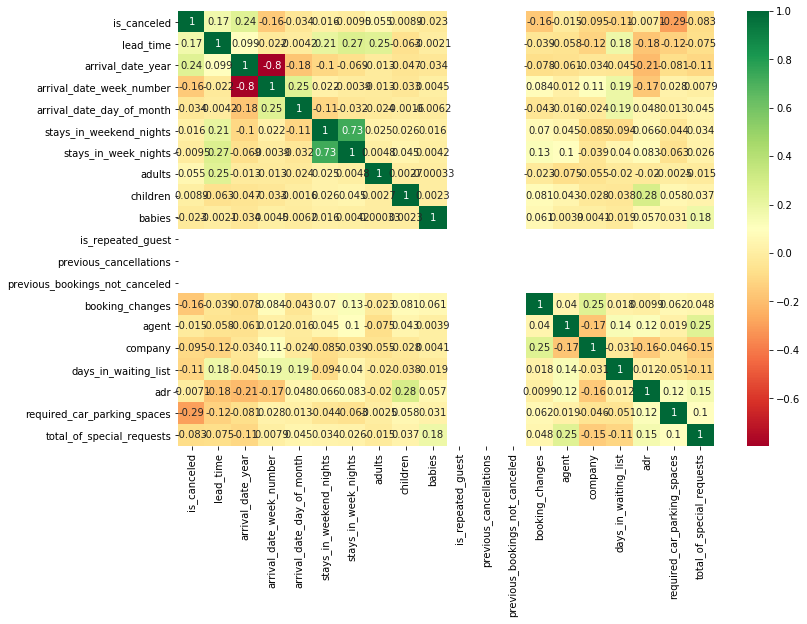

In [16]:
hotel = df_clean.toPandas()
plt.figure(figsize=(12,8))
sns.heatmap(hotel.corr(),annot=True,cmap='RdYlGn')

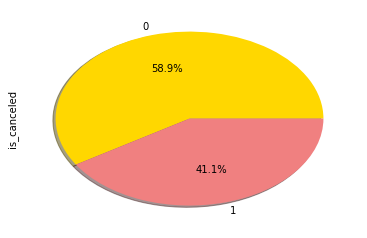

In [17]:
cols = ['gold', 'lightcoral']
hotel['is_canceled'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, colors=cols)

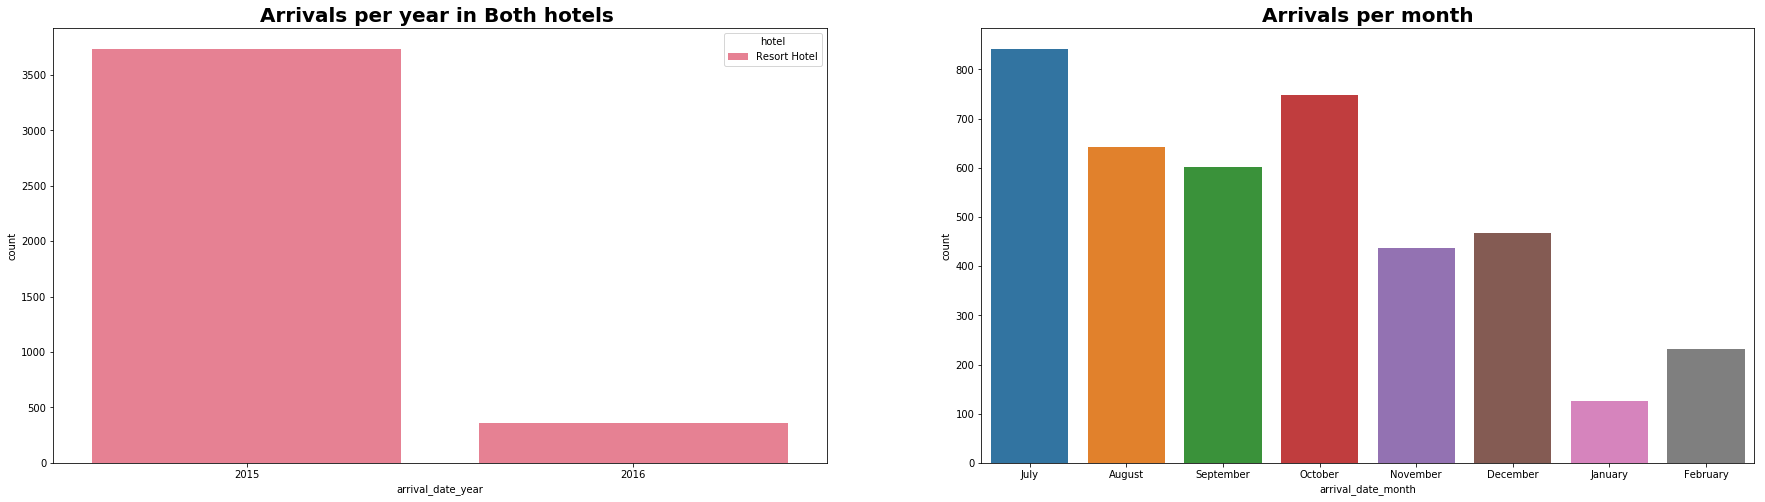

In [20]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='arrival_date_year',hue='hotel', data=hotel,palette='husl')
plt.title("Arrivals per year in Both hotels ",fontweight="bold", size=20)
plt.subplot(1, 2, 2)
sns.countplot(data = hotel, x = 'arrival_date_month')
plt.title('Arrivals per month',fontweight="bold", size=20)
plt.subplots_adjust(right=1.7)

plt.show()

# Modeling Logistic

In [6]:
from pyspark.ml.classification import LogisticRegression
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns: "label" and "features".

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [7]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults", "children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

selected = num_features + cat_features + ["is_canceled"]
my_cols = df_clean.select(selected)

In [8]:
for num_feature in num_features:
    print(num_feature,": ",abs(df_clean.stat.corr("is_canceled", num_feature)))

lead_time :  0.29312335576071835
arrival_date_week_number :  0.008148065395053274
arrival_date_day_of_month :  0.00613007886275798
stays_in_weekend_nights :  0.0017910780782638314
stays_in_week_nights :  0.024764629045870484
adults :  0.06001721283955587
children :  0.005036254836439652
babies :  0.032491089208332935
is_repeated_guest :  0.08479341835709014
previous_cancellations :  0.11013280822284209
previous_bookings_not_canceled :  0.05735772316594581
agent :  0.04652945245026956
company :  0.08299479643487706
required_car_parking_spaces :  0.19549781749449852
total_of_special_requests :  0.23465777396902449
adr :  0.04755659788038999


In [9]:
my_cols.columns

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'agent',
 'company',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'adr',
 'hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'is_canceled']

In [10]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
arrival_date_month_indexer = StringIndexer(inputCol='arrival_date_month',outputCol='arrival_date_monthIndex')
arrival_date_month_encoder = OneHotEncoder(inputCol='arrival_date_monthIndex',outputCol='arrival_date_monthVec')

meal_indexer = StringIndexer(inputCol='meal',outputCol='mealIndex')
meal_encoder = OneHotEncoder(inputCol='mealIndex',outputCol='mealVec')

hotel_indexer = StringIndexer(inputCol='hotel',outputCol='hotelIndex')
hotel_encoder = OneHotEncoder(inputCol='hotelIndex',outputCol='hotelVec')

market_segment_indexer = StringIndexer(inputCol='market_segment',outputCol='market_segmentIndex')
market_segment_encoder = OneHotEncoder(inputCol='market_segmentIndex',outputCol='market_segmentVec')

distribution_channel_indexer = StringIndexer(inputCol='distribution_channel',outputCol='distribution_channelIndex')
distribution_channel_encoder = OneHotEncoder(inputCol='distribution_channelIndex',outputCol='distribution_channelVec')

reserved_room_type_indexer = StringIndexer(inputCol='reserved_room_type',outputCol='reserved_room_typeIndex')
reserved_room_type_encoder = OneHotEncoder(inputCol='reserved_room_typeIndex',outputCol='reserved_room_typeVec')

deposit_type_indexer = StringIndexer(inputCol='deposit_type',outputCol='deposit_typeIndex')
deposit_type_encoder = OneHotEncoder(inputCol='deposit_typeIndex',outputCol='deposit_typeVec')

customer_type_indexer = StringIndexer(inputCol='customer_type',outputCol='customer_typeIndex')
customer_type_encoder = OneHotEncoder(inputCol='customer_typeIndex',outputCol='customer_typeVec')

cat_vec_features = ["arrival_date_monthVec","mealVec", "hotel", "market_segmentVec",
                "distribution_channelVec","reserved_room_typeVec","deposit_typeVec","customer_typeVec"]
features = num_features + cat_vec_features


In [11]:
assembler = VectorAssembler(inputCols=num_features, outputCol="features")
output = assembler.transform(my_cols)

In [12]:
from pyspark.ml import Pipeline
log_reg_hotel = LogisticRegression(featuresCol='features',labelCol='is_canceled')
pipeline = Pipeline(stages=[arrival_date_month_indexer, 
                           meal_indexer, hotel_indexer, market_segment_indexer, distribution_channel_indexer, 
                           reserved_room_type_indexer, deposit_type_indexer, customer_type_indexer, 
                            arrival_date_month_encoder, meal_encoder, hotel_encoder, market_segment_encoder, 
                           distribution_channel_encoder, reserved_room_type_encoder, deposit_type_encoder, 
                           customer_type_encoder, assembler, log_reg_hotel])

In [13]:
train_log_data, test_log_data = my_cols.randomSplit([0.7,.3])

In [14]:
fit_model_log = pipeline.fit(train_log_data)

In [15]:
results = fit_model_log.transform(test_log_data)

In [16]:
results.select('is_canceled','prediction').show()

+-----------+----------+
|is_canceled|prediction|
+-----------+----------+
|          0|       1.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
|          0|       0.0|
+-----------+----------+
only showing top 20 rows



In [17]:
totalResults = results.select('is_canceled','prediction')

correctResults = totalResults.filter(totalResults['is_canceled'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 
print("Logistic")
print("Accuracy: ", countTC/countTR)

Correct: 35835
Total Correct: 25985
Logistic
Accuracy:  0.7251290637644761


In [28]:
# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='is_canceled')
AUC = my_eval.evaluate(results)
print("AUC for Logistic regression:", AUC)

AUC for Logistic regression: 0.6696036073467676


# Modeling RF

In [18]:
final_data = output.select("features",'is_canceled')

In [19]:
train_data,test_data = my_cols.randomSplit([0.7,0.3])

In [20]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol='is_canceled',featuresCol='features')
pipeline = Pipeline(stages=[arrival_date_month_indexer, 
                           meal_indexer, hotel_indexer, market_segment_indexer, distribution_channel_indexer, 
                           reserved_room_type_indexer, deposit_type_indexer, customer_type_indexer, 
                            arrival_date_month_encoder, meal_encoder, hotel_encoder, market_segment_encoder, 
                           distribution_channel_encoder, reserved_room_type_encoder, deposit_type_encoder, 
                           customer_type_encoder, assembler, rfc])

In [21]:
rfc_model = pipeline.fit(train_data)

In [22]:
rfc_predictions = rfc_model.transform(test_data)

In [23]:
# Let's start off with binary classification.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Note that the label column isn't named label, it's named PrivateIndex in this case.
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'is_canceled')

In [24]:
# RFC improves accuracy but also model complexity. RFC outperforms DTC in nearly every situation.
print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))

RFC
0.8089616818126256


In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="is_canceled", predictionCol="prediction", metricName="accuracy")
rfc_acc = acc_evaluator.evaluate(rfc_predictions)

In [26]:
print("Here are the results!")
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))

Here are the results!
----------------------------------------
A random forest ensemble has an accuracy of: 74.81%


In [29]:
print("AUC for Random Forest:", my_binary_eval.evaluate(rfc_predictions))

AUC for Random Forest: 0.8089616818126256
